In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=9
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 4 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  3183.0471014492737
Friday area:  2525.0833333333367
Weekend area:  991.2083333333352
Weekday maximum:  167.43478260869566
Friday maximum:  129.66666666666666
Weekend maximum:  47.0


## MATHEMATICAL MODEL - CDF Subtraction

In [3]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_areanormalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_areanormalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_areanormalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

errors = np.ones(np.shape(training_weekdays_norm))
optimal_params_weekdaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekdays_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 10000})



Optimization terminated successfully.
         Current function value: 0.041222
         Iterations: 139
         Function evaluations: 242


In [4]:
import math 
var_weekdaytn_time = np.mean(errors)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.00611

stdv per time-step


In [5]:
optimal_params_weekdaytn

 final_simplex: (array([[0.3381864 , 0.04045137, 0.7232386 , 0.11797305],
       [0.3381862 , 0.04045164, 0.72323844, 0.11797228],
       [0.33818601, 0.04045123, 0.7232393 , 0.11797216],
       [0.33818607, 0.04045126, 0.72323851, 0.11797316],
       [0.338186  , 0.04045165, 0.72323906, 0.11797262]]), array([0.04122178, 0.04122178, 0.04122178, 0.04122178, 0.04122178]))
           fun: 0.04122178324214991
       message: 'Optimization terminated successfully.'
          nfev: 242
           nit: 139
        status: 0
       success: True
             x: array([0.3381864 , 0.04045137, 0.7232386 , 0.11797305])

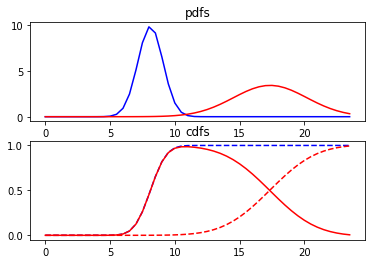

In [6]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [7]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.3381864 , 0.04045137, 0.7232386 , 0.11797305])

In [8]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")

#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


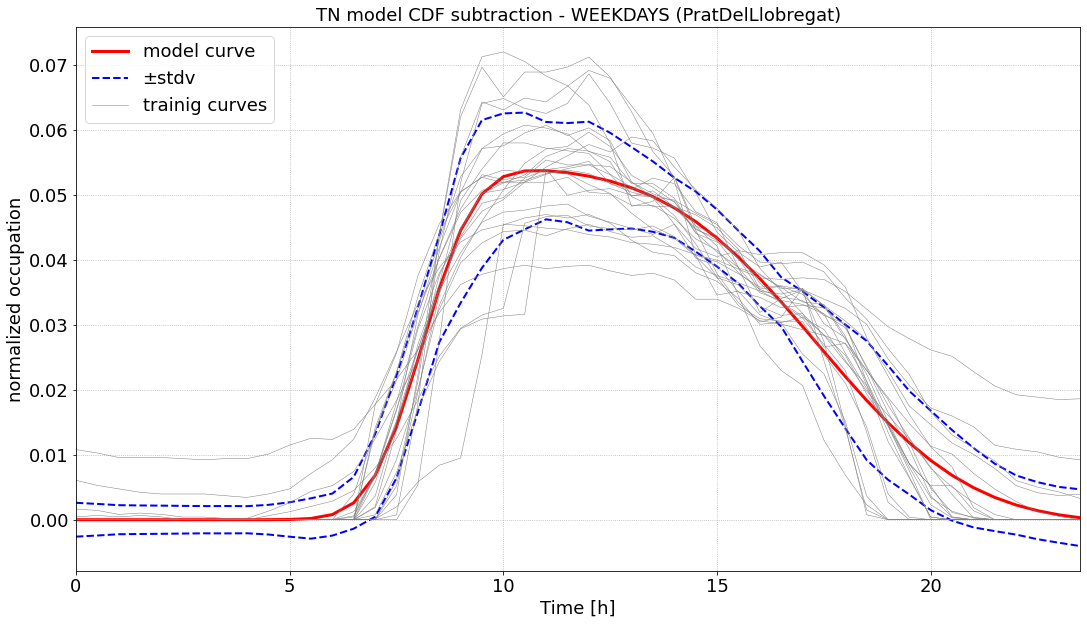

In [9]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

### FRIDAYS

In [10]:
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_fridaytn = minimize(model_tn_areaN, parameters_tn, args=(training_fridays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

errors = np.ones(np.shape(training_fridays_norm))
optimal_params_fridaytn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_fridays_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


Optimization terminated successfully.
         Current function value: 0.019149
         Iterations: 163
         Function evaluations: 285


In [11]:
var_fridaytn = np.mean(errors)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.01153

stdv per time-step


In [12]:
optimal_params_fridaytn

 final_simplex: (array([[0.35818195, 0.05871511, 0.59837348, 0.15844887],
       [0.3581818 , 0.05871488, 0.59837369, 0.15844896],
       [0.35818193, 0.05871474, 0.59837426, 0.15844845],
       [0.35818224, 0.05871502, 0.59837268, 0.15844925],
       [0.35818194, 0.05871503, 0.5983738 , 0.15844905]]), array([0.01914864, 0.01914864, 0.01914864, 0.01914864, 0.01914864]))
           fun: 0.019148636065541815
       message: 'Optimization terminated successfully.'
          nfev: 285
           nit: 163
        status: 0
       success: True
             x: array([0.35818195, 0.05871511, 0.59837348, 0.15844887])

In [13]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

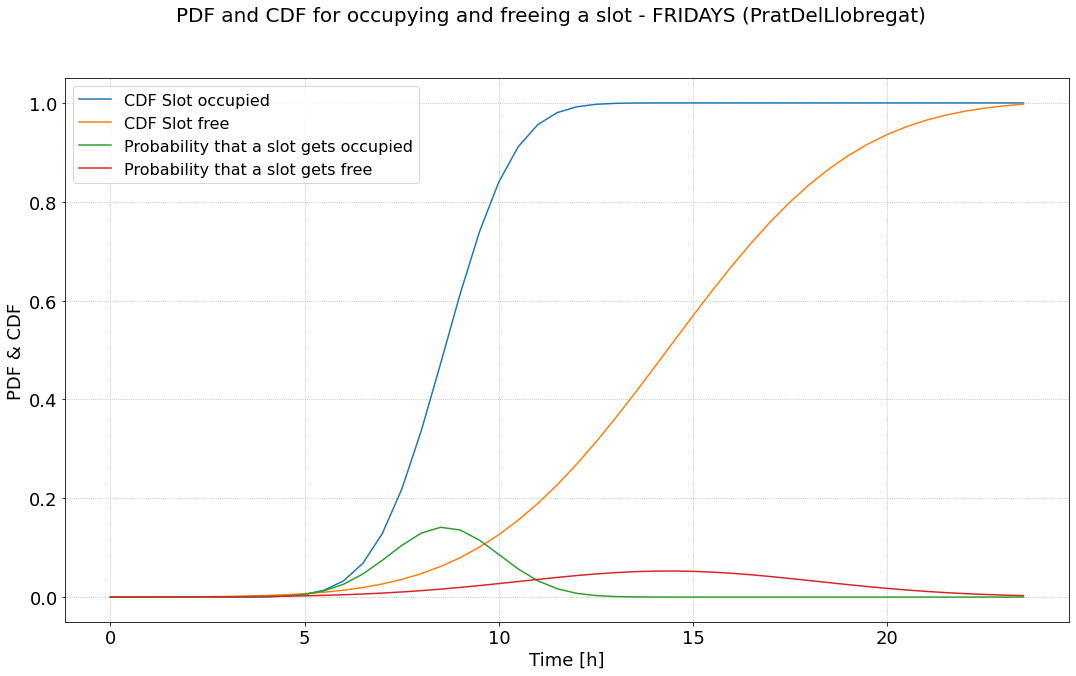

In [14]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_fri, label="CDF Slot occupied")
plt.plot(time, cdf2_fri, label="CDF Slot free")
plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

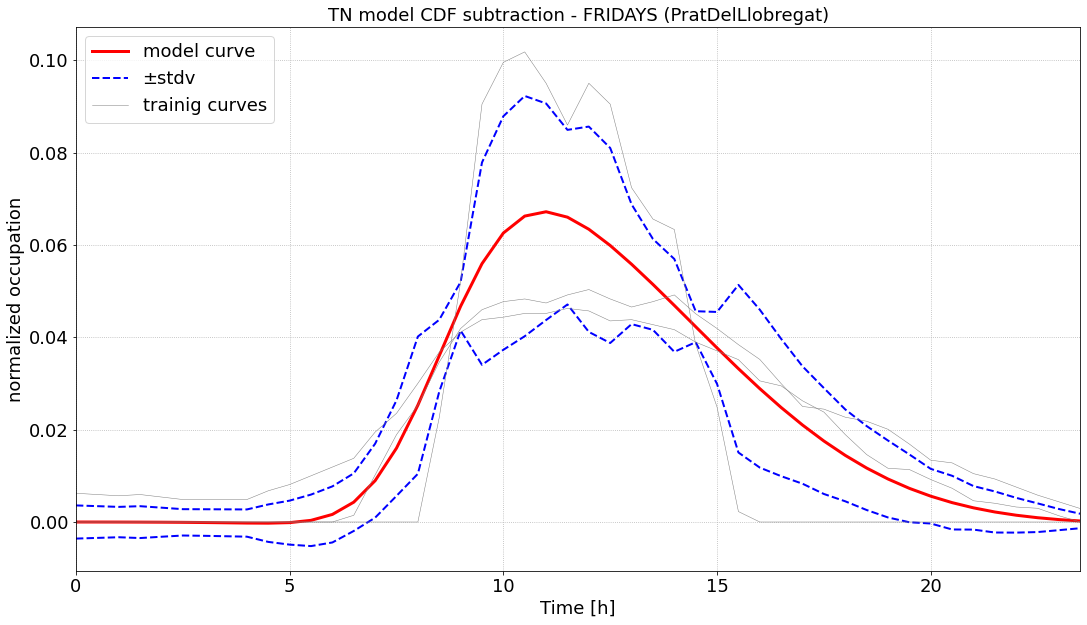

In [15]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

### WEEKENDS

In [16]:
parameters_tn = np.array([.2 ,.05,.7,.1])
errors = np.ones(np.shape(training_weekends_norm))    
if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='SLSQP',
    #                                   bounds=((0, None), (0, None),(0, None),(0, None)),
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
else:
    #optimal_params_weekendtn = minimize(model_tn_areaN_args, parameters_tn, args=(training_weekends_norm), method='Nelder-Mead',
    #                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})     
    
    optimal_params_weekendtn = minimize(model_tn_areaN_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


Optimization terminated successfully.
         Current function value: 0.027054
         Iterations: 237
         Function evaluations: 388


In [17]:
var_weekendtn = np.mean(errors)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors,0))
print('stdv per time-step')
#or i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.01062

stdv per time-step


In [18]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.33752738, 0.1313607 , 0.9549782 , 0.32944027])

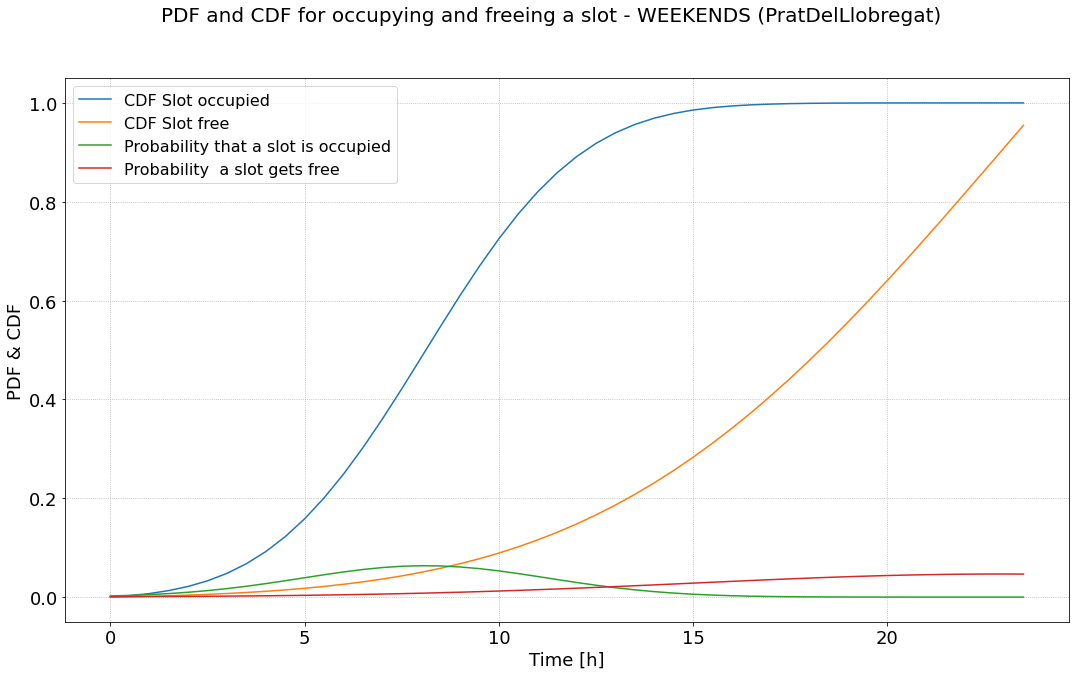

In [19]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_we, label="CDF Slot occupied")
plt.plot(time, cdf2_we, label="CDF Slot free")
plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

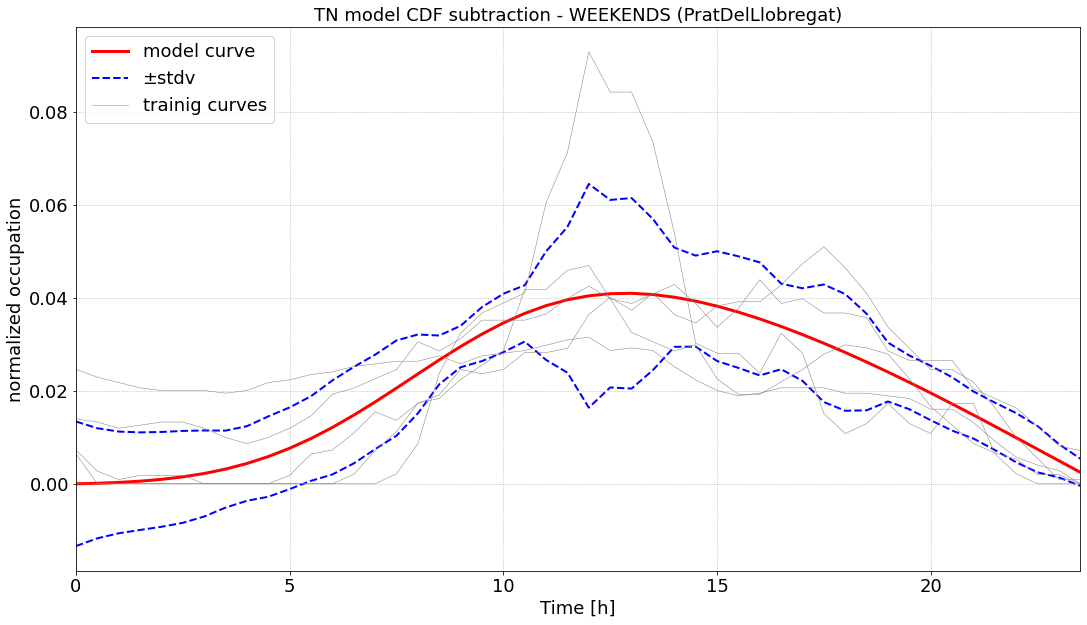

In [20]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_weekends_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [21]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS PratDelLlobregat -----------
Mean Arrival Time   = 08:06h
stdv Arrival        =  0:58h
Mean Departure Time = 17:21h
stdv Departure      =  2:49h
--------- FRIDAYS PratDelLlobregat -----------
Mean Arrival Time   = 08:35h
stdv Arrival        =  1:24h
Mean Departure Time = 14:21h
stdv Departure      =  3:48h
--------- WEEKENDS PratDelLlobregat -----------
Mean Arrival Time   = 08:06h
stdv Arrival        =  3:09h
Mean Departure Time = 22:55h
stdv Departure      =  7:54h


In [22]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

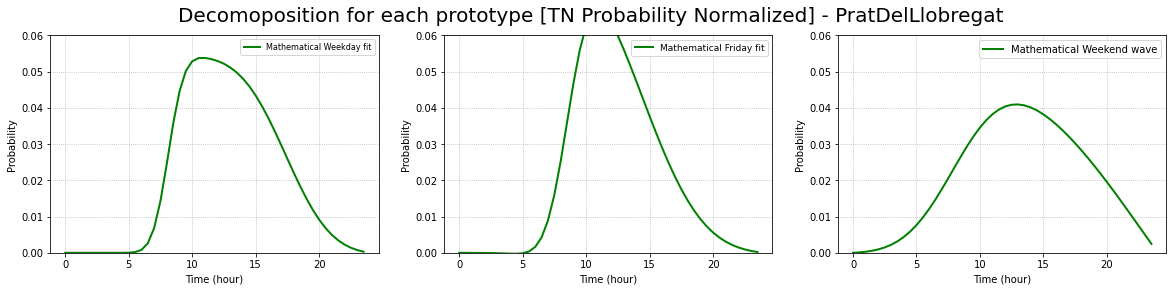

In [23]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Normalized] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time2, tn_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time2, tn_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time2, tn1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');

In [24]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [25]:

tn_weekday = tn_weekday_n*weekday_area + weekday_offset
tn_friday = tn_friday_n*friday_area + friday_offset
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 



In [26]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
18.838987423032464  ±  5.574463167040743
15.063353715978984  ±  6.403460333748267
14.081296744622138  ±  7.295745114931555
17.977695936740982  ±  7.253767372729093
16.881725409608418  ±  8.832552504004807
16.124584163941346  ±  11.771504248595411
11.307292044056375  ±  9.9646500022606


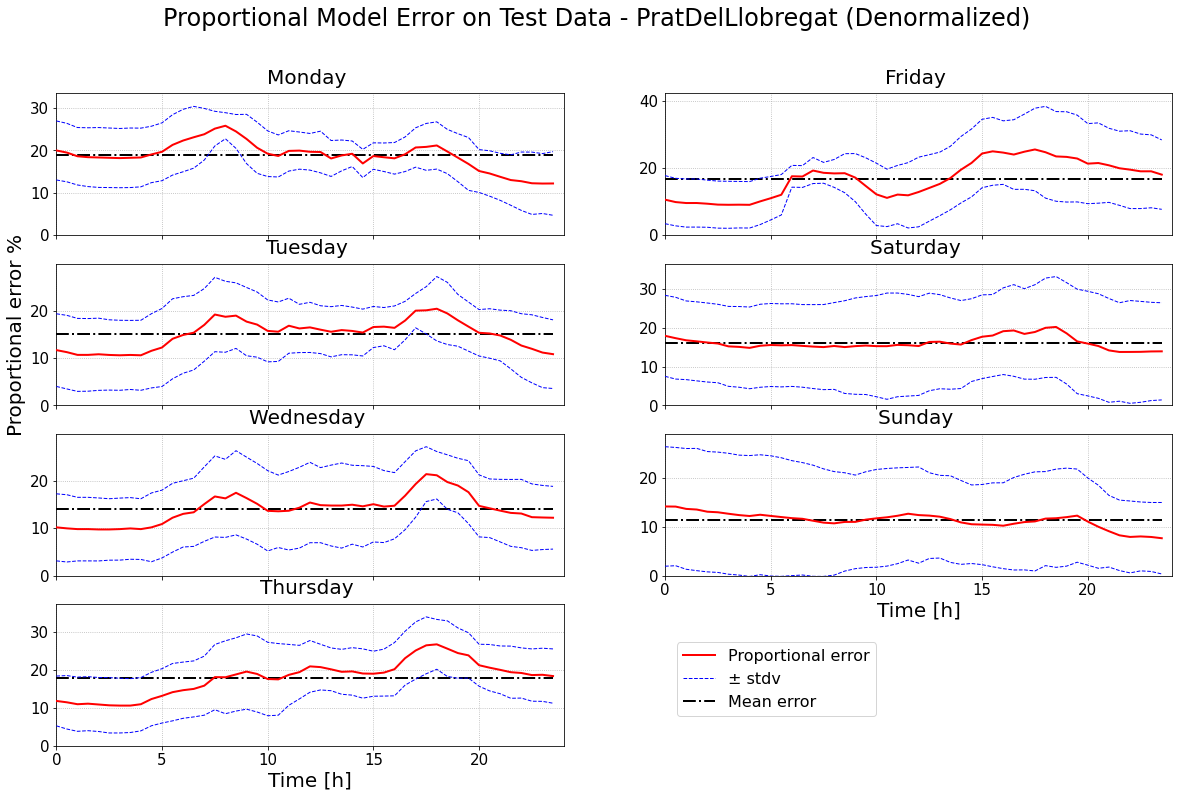

In [27]:
[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)


fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn[~np.isnan(stdv_error_monday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday ', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday ', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn[~np.isnan(stdv_error_wednesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday ', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn[~np.isnan(stdv_error_thursday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday ', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday ', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday ', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday ', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'.pdf',bbox_inches='tight');
#ax[2,2].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))



In [28]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [29]:
f = open('data/'+current_parking+'_testError.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [30]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

#### MONDAY

2020-02-24
Real Monday scaled prtotype error:  79.88 %
Real Monday scaled prtotype STDV:  57.09978482575149
Real Monday scaled TN error:  50.16 %
Real Monday scaled TN STDV:  34.05119625957575
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  42.46 %
Real Monday scaled prtotype STDV:  29.414581163118015
Real Monday scaled TN error:  22.99 %
Real Monday scaled TN STDV:  14.488434270322172
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  65.21 %
Real Monday scaled prtotype STDV:  47.06235930988283
Real Monday scaled TN error:  36.78 %
Real Monday scaled TN STDV:  27.632603938948648
_____________________________________________________________


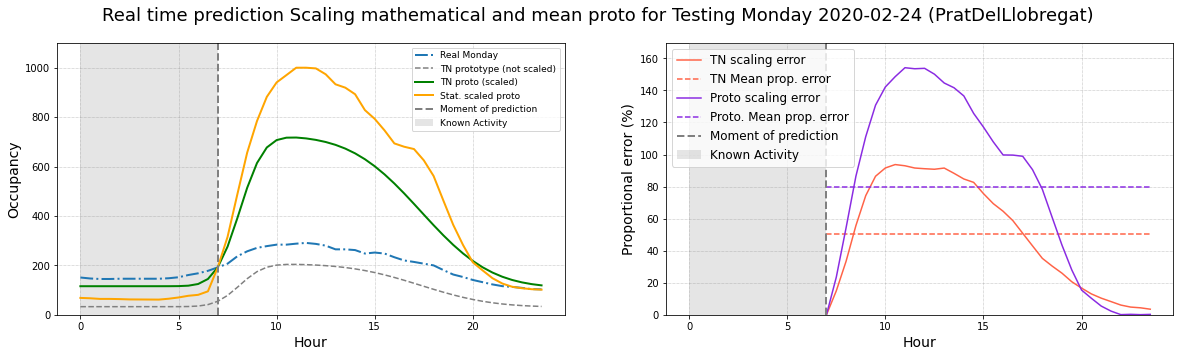

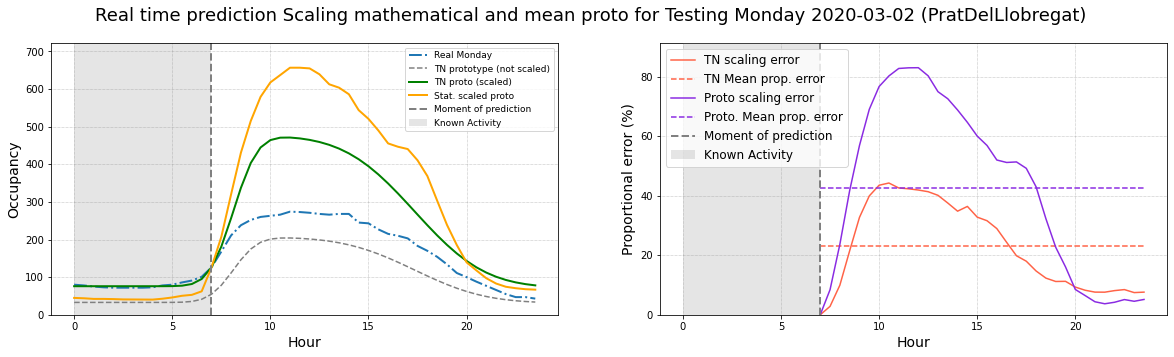

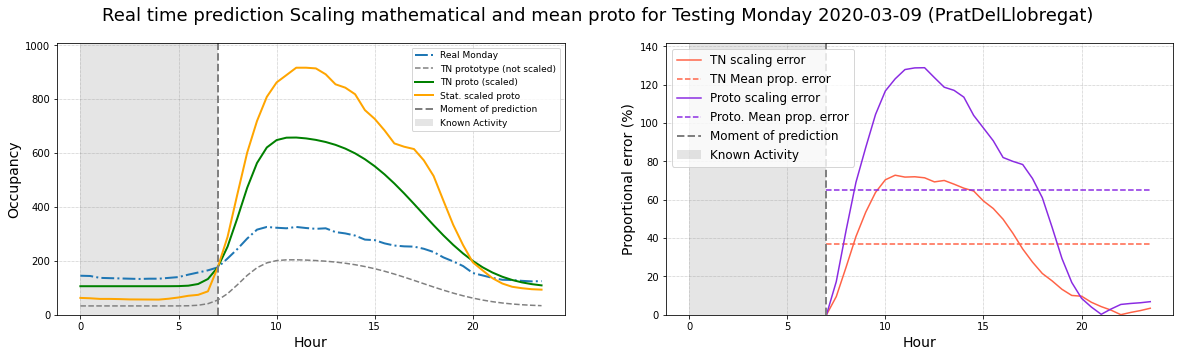

In [31]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 7
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

#### TUESDAY

2020-02-25
Real Tuesday scaled prtotype error:  7.9 %
Real Tuesday scaled prtotype STDV:  7.001710003374616
Real Tuesday scaled TN error:  6.97 %
Real Tuesday scaled TN STDV:  5.303406105936922
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  4.53 %
Real Tuesday scaled prtotype STDV:  3.3952158872142184
Real Tuesday scaled TN error:  4.24 %
Real Tuesday scaled TN STDV:  3.133572015722813
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  9.58 %
Real Tuesday scaled prtotype STDV:  7.013932810636994
Real Tuesday scaled TN error:  8.02 %
Real Tuesday scaled TN STDV:  6.179998108474862
_____________________________________________________________


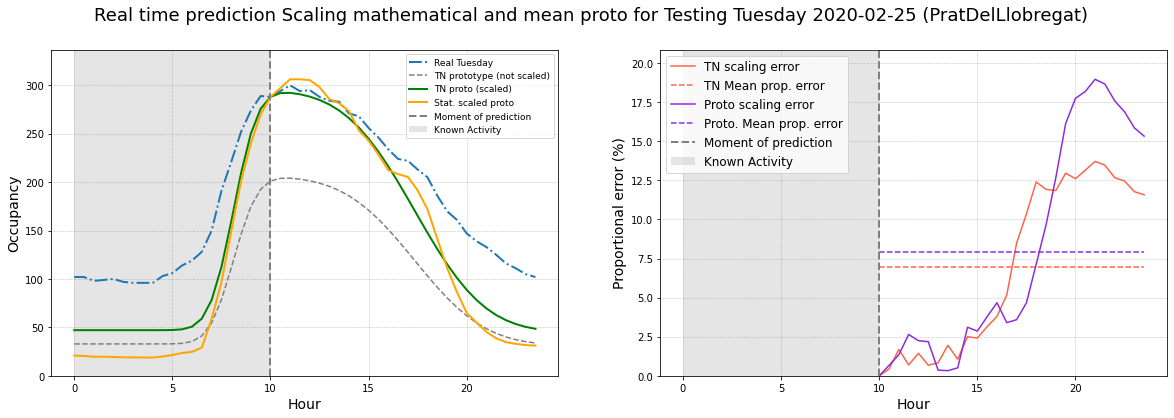

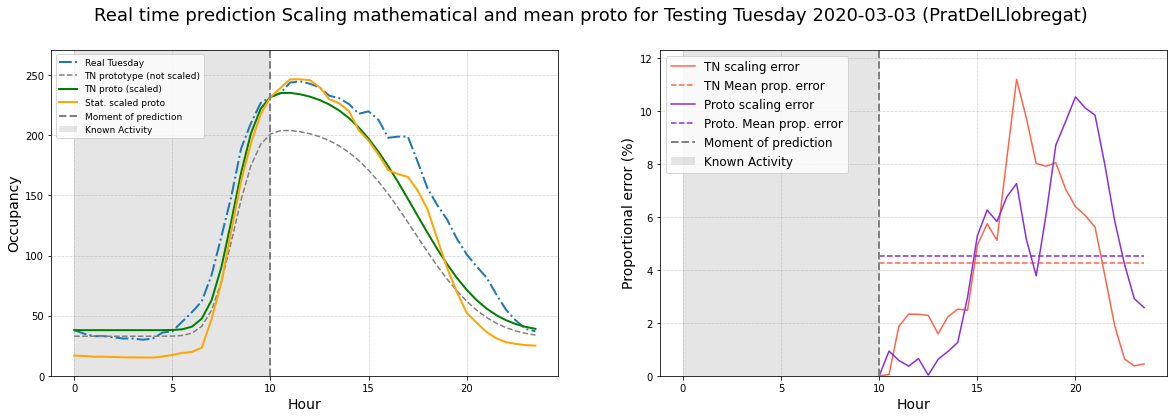

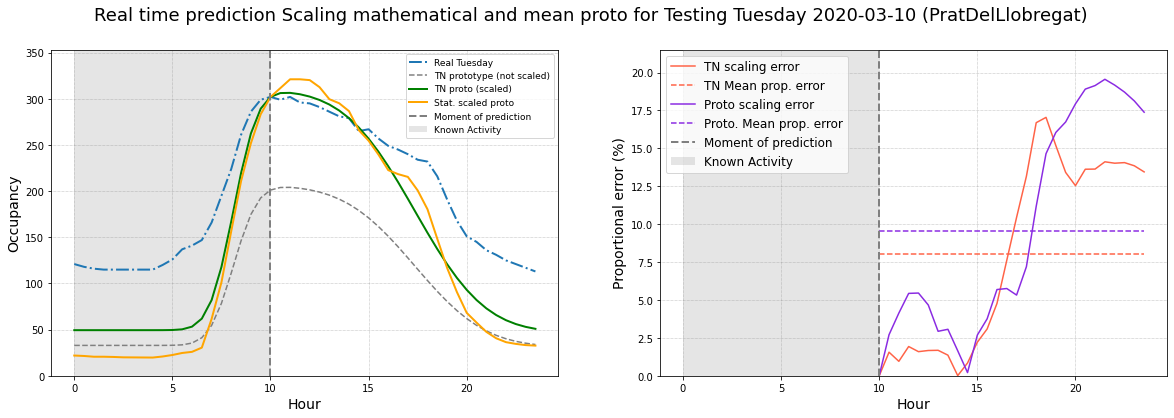

In [32]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### WEDNESDAY

2020-02-26
Real Wednesday scaled prtotype error:  12.46 %
Real Wednesday scaled prtotype STDV:  7.782366850866104
Real Wednesday scaled TN error:  10.77 %
Real Wednesday scaled TN STDV:  6.091946602735903
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  6.24 %
Real Wednesday scaled prtotype STDV:  3.585400558482812
Real Wednesday scaled TN error:  5.05 %
Real Wednesday scaled TN STDV:  4.3083711355657694
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  8.77 %
Real Wednesday scaled prtotype STDV:  6.318798520180778
Real Wednesday scaled TN error:  7.3 %
Real Wednesday scaled TN STDV:  4.609933194201286
_____________________________________________________________


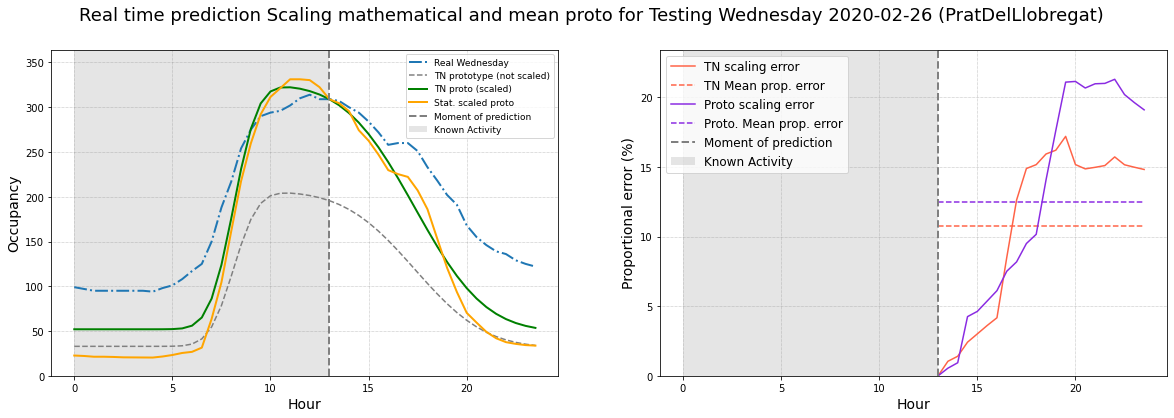

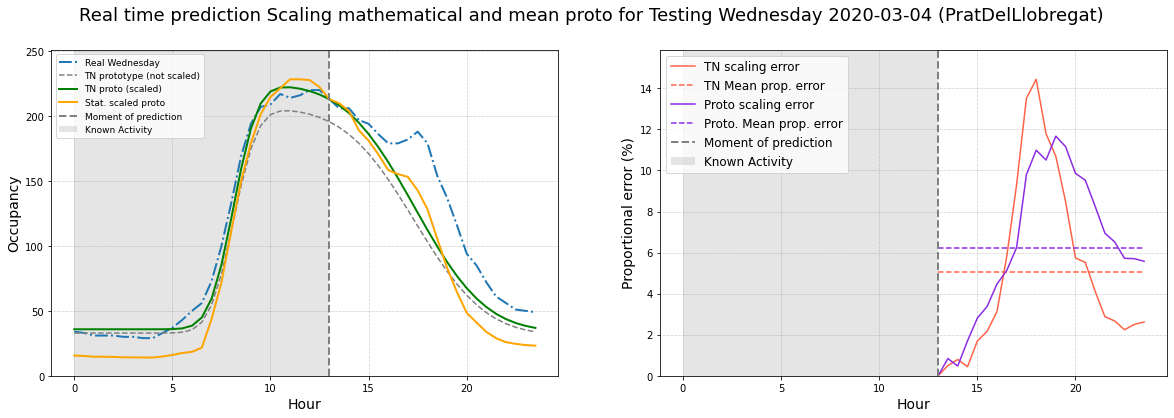

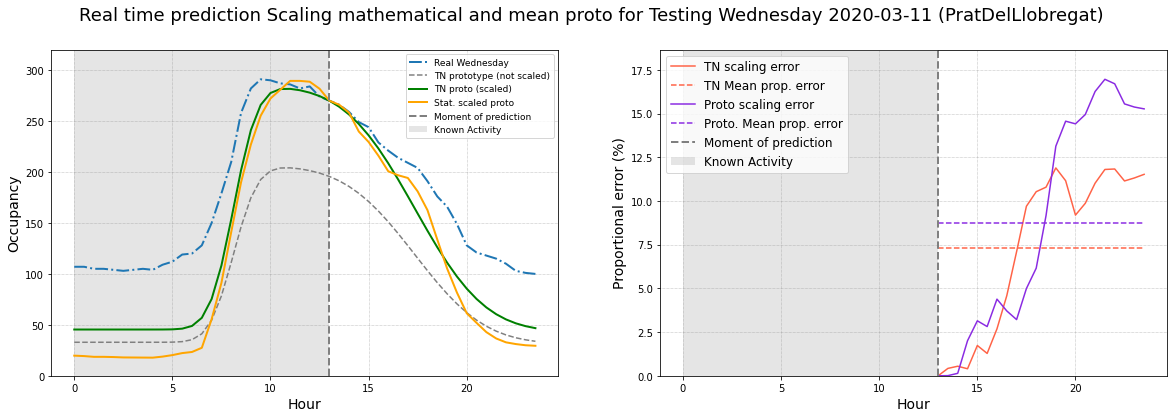

In [33]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### THURSDAY

2020-02-27
Real Thursday scaled prtotype error:  16.93 %
Real Thursday scaled prtotype STDV:  10.343210055710152
Real Thursday scaled TN error:  15.14 %
Real Thursday scaled TN STDV:  8.769893130553884
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  8.55 %
Real Thursday scaled prtotype STDV:  5.749959335922432
Real Thursday scaled TN error:  7.09 %
Real Thursday scaled TN STDV:  4.896300760106042
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  10.88 %
Real Thursday scaled prtotype STDV:  7.569151155109426
Real Thursday scaled TN error:  9.33 %
Real Thursday scaled TN STDV:  5.891640288189701
_____________________________________________________________


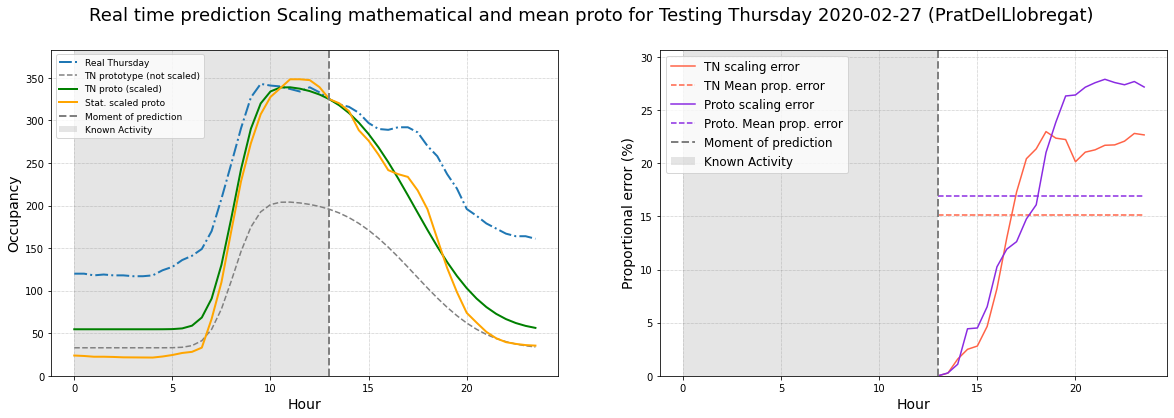

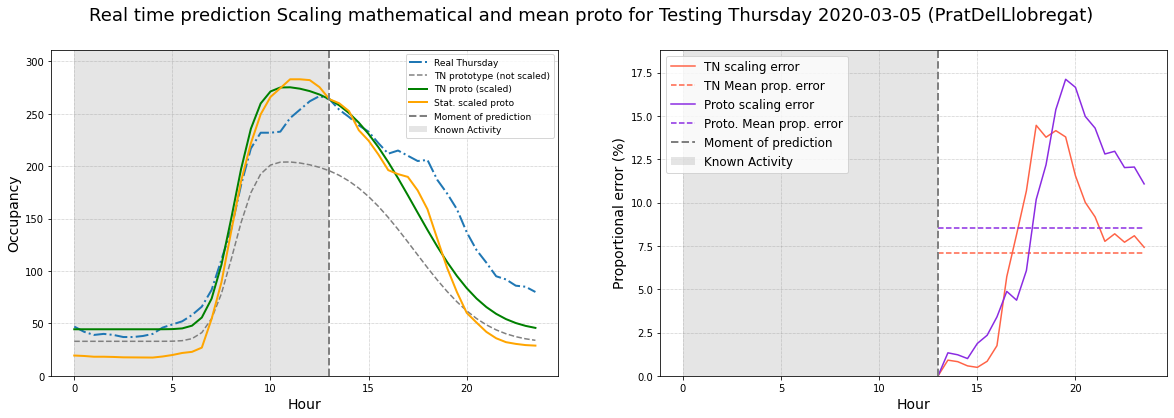

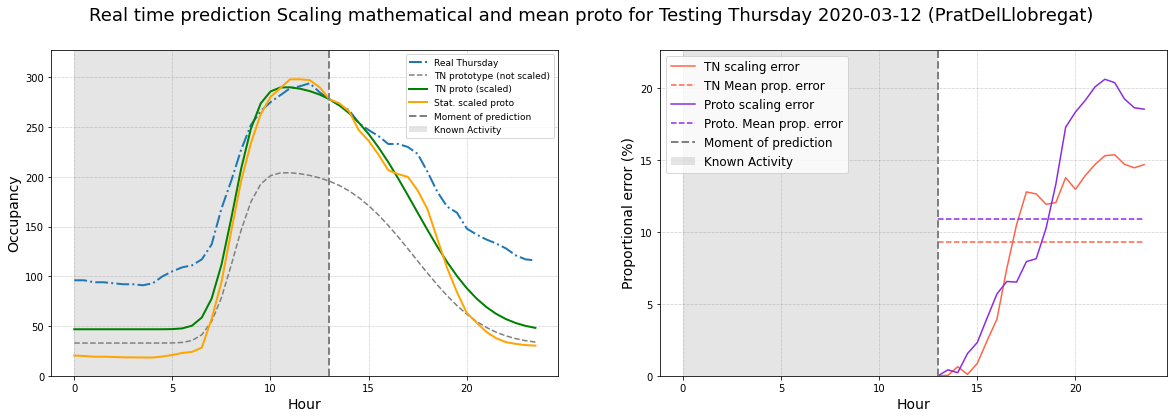

In [34]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### FRIDAY

2020-02-28
Real Friday scaled prtotype error:  5.3 %
Real Friday scaled prtotype STDV:  3.24884796974072
Real Friday scaled TN error:  2.66 %
Real Friday scaled TN STDV:  1.3063287345726533
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  17.32 %
Real Friday scaled prtotype STDV:  7.399409122620584
Real Friday scaled TN error:  14.11 %
Real Friday scaled TN STDV:  5.225428619964109
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  3.55 %
Real Friday scaled prtotype STDV:  2.928507446042784
Real Friday scaled TN error:  1.44 %
Real Friday scaled TN STDV:  0.8755773447934055
_____________________________________________________________


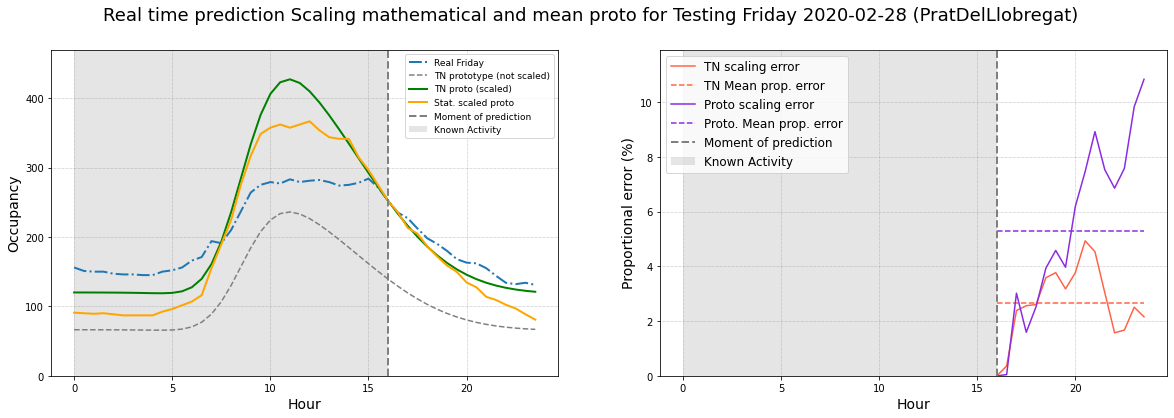

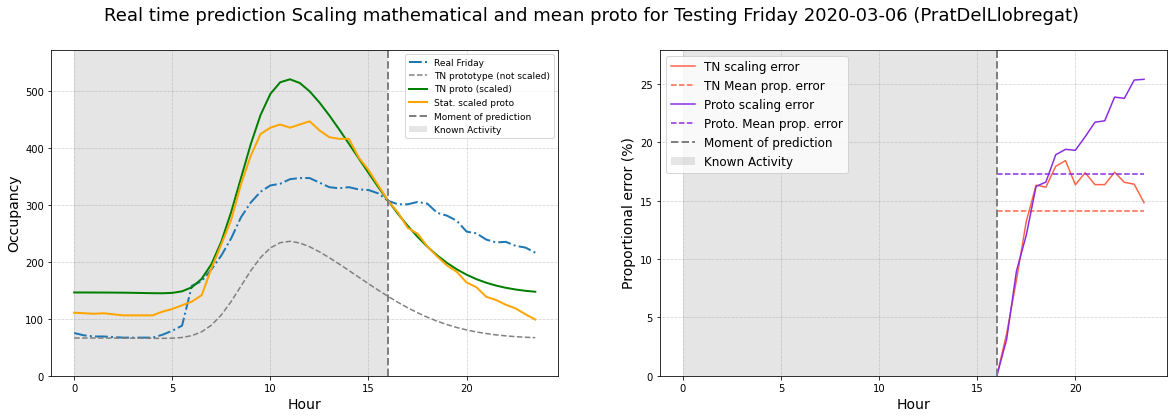

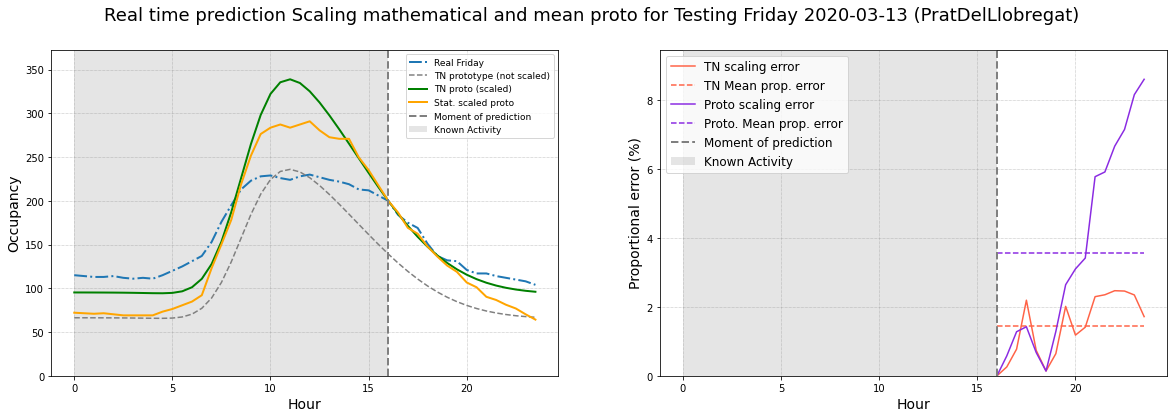

In [35]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
  
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1
    

### WEEKEND

### SATURDAY

2020-02-29
Real Saturday scaled prtotype error:  3.96 %
Real Saturday scaled prtotype STDV:  2.2051042447648954
Real Saturday scaled TN error:  4.6 %
Real Saturday scaled TN STDV:  3.1437568448181126
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  9.57 %
Real Saturday scaled prtotype STDV:  8.154023705262562
Real Saturday scaled TN error:  6.71 %
Real Saturday scaled TN STDV:  3.199026455762749
_____________________________________________________________
2020-03-14
Real Saturday scaled prtotype error:  3.28 %
Real Saturday scaled prtotype STDV:  2.9523736502962827
Real Saturday scaled TN error:  1.87 %
Real Saturday scaled TN STDV:  1.3685769352855497
_____________________________________________________________


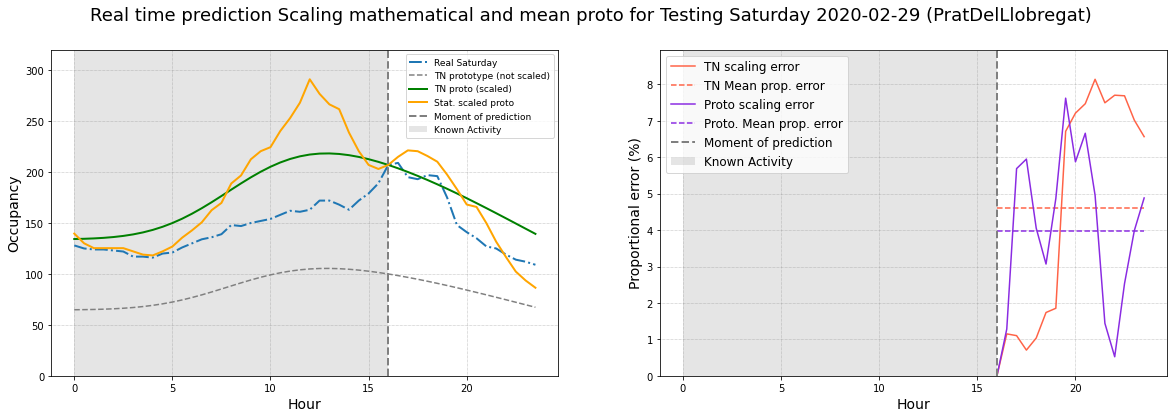

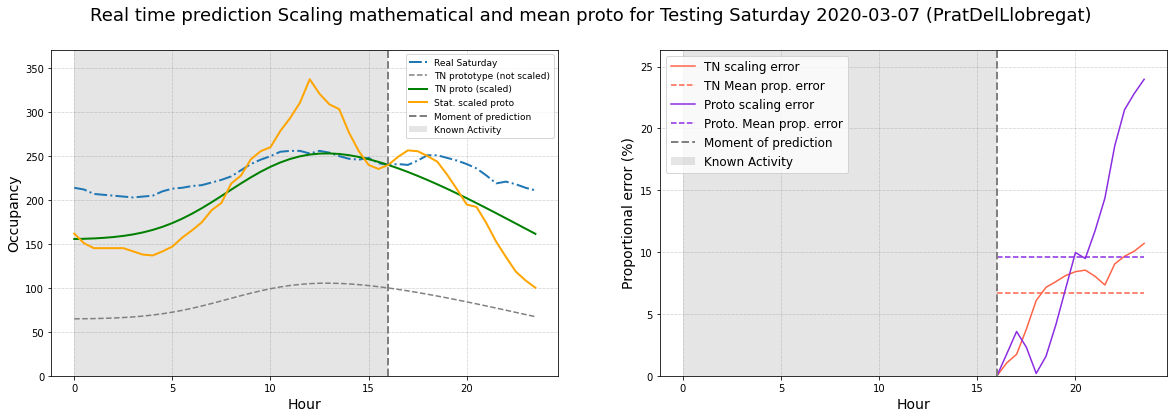

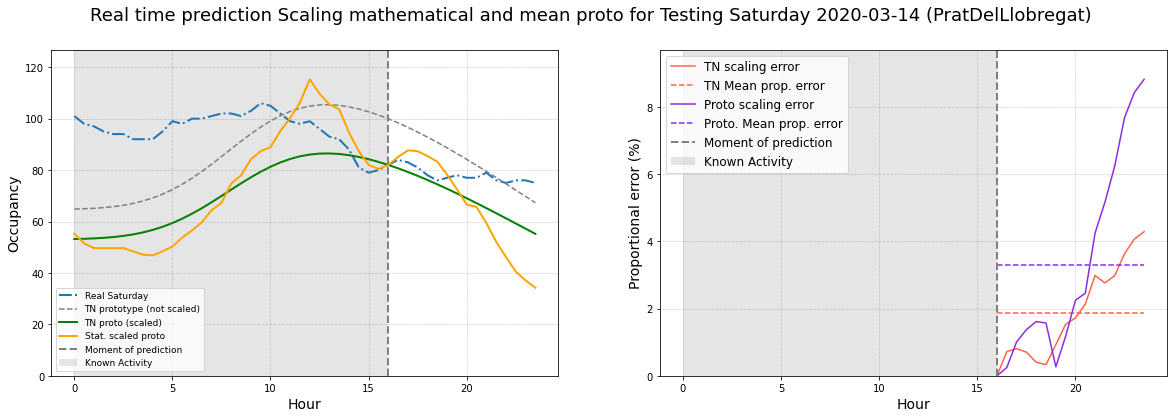

In [36]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

2020-03-01
Real Sunday scaled prtotype error:  3.1 %
Real Sunday scaled prtotype STDV:  2.707163234986001
Real Sunday scaled TN error:  1.67 %
Real Sunday scaled TN STDV:  1.126753420030724
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  9.16 %
Real Sunday scaled prtotype STDV:  4.4688843800355444
Real Sunday scaled TN error:  2.37 %
Real Sunday scaled TN STDV:  1.7818414659618593
_____________________________________________________________
2020-03-15
Real Sunday scaled prtotype error:  2.81 %
Real Sunday scaled prtotype STDV:  2.1678441012498553
Real Sunday scaled TN error:  0.63 %
Real Sunday scaled TN STDV:  0.6769223500736947
_____________________________________________________________


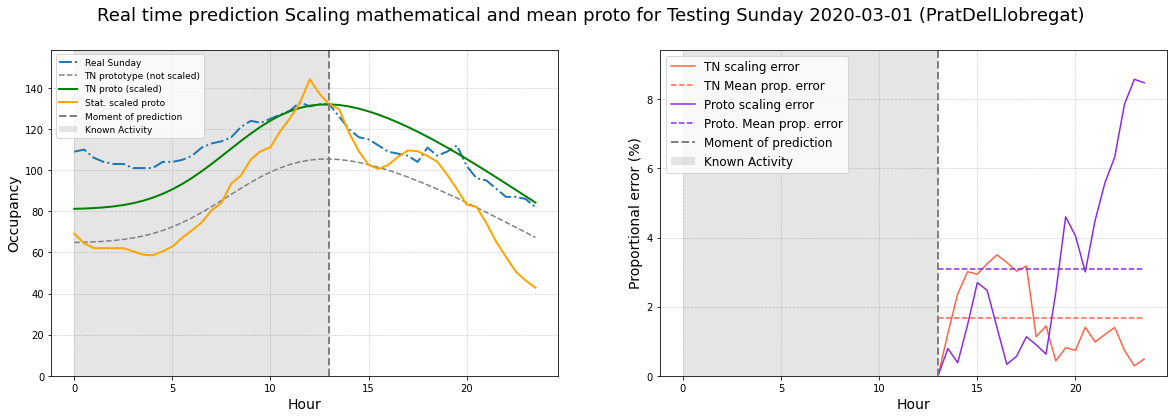

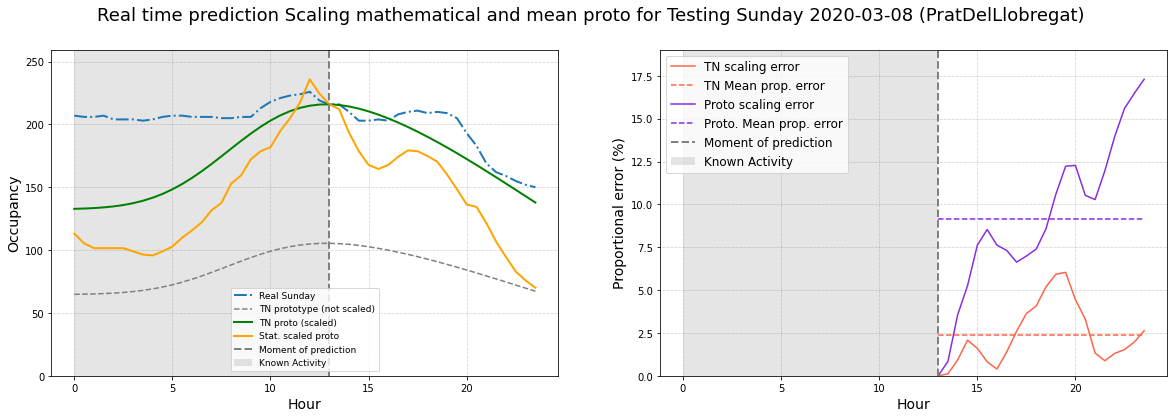

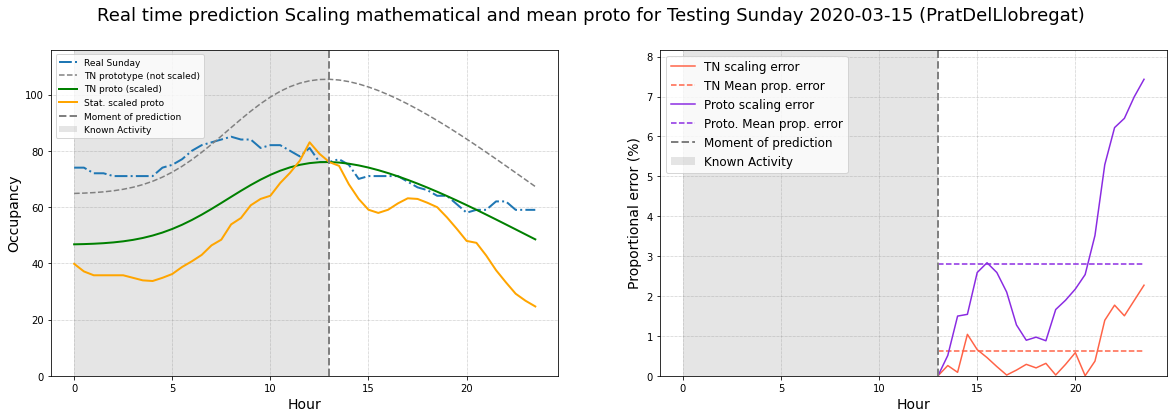

In [37]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

# Store protos, params, areas and offsets

In [38]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_tn_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_tn_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_tn_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in tn_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in tn1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in tn_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'CDF subtraction_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'CDF subtraction_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'CDF subtraction_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'CDF subtraction_weekday_params'] = weekday_tn_params
# df_prototypes.at[index,'CDF subtraction_friday_params']  = friday_tn_params
# df_prototypes.at[index,'CDF subtraction_weekend_params'] = weekend_tn_params

# df_prototypes.at[index,'CDF subtraction_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'CDF subtraction_friday_area']  = friday_mean_area
# df_prototypes.at[index,'CDF subtraction_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'CDF subtraction_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'CDF subtraction_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'CDF subtraction_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [39]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'CDF subtraction_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [40]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [41]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [42]:
# hist_friday_proto.tolist()